<a href="https://colab.research.google.com/github/aimetz/551-Final-Project/blob/main/08_NN_template_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Declare your libraries:


In [1]:
#| label: libraries-py
#| include: false
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split

In [2]:
cc = pd.read_csv("https://www.dropbox.com/s/gyuyxicv27g86zr/credit_card_status.csv?dl=1")

cc = cc.sample(5000)
cc = cc.drop(["ID", "STATUS_TYPICAL"], axis = 1)
cc['STATUS_WORST'] = cc['STATUS_WORST'].astype('category')

cc_train, cc_validate = train_test_split(cc, test_size = 0.1, stratify = cc['STATUS_WORST'])

# Part One: Tuning


I have my own code where I implemented a Neural network from scratch. I will use that instead. Here is the following code:
* 90% of the way through doing this I made my life so much harder I should have just used sklearns adaptation

In [3]:
"""
A Tensor is an N-dimensional Array
"""
from numpy import ndarray as Tensor

"""
A layer passes its inputs forward and propagates gradients backward
"""
from typing import Dict, Callable, Sequence, Iterator, Tuple, NamedTuple

import json

F = Callable[[Tensor], Tensor]
Batch = NamedTuple("Batch", [("inputs", Tensor), ("targets", Tensor)])


class Layer:
    def __init__(self) -> None:
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}
        self.inputs: Tensor or None = None

    def forward(self, inputs: Tensor) -> Tensor:
        """
        Push inputs forward
        """
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        """
        Backpropagate gradient through the layer
        """
        raise NotImplementedError



"""
A layer passes its inputs forward and propagates gradients backward
"""
class Linear(Layer):
    """
    computes output = inputs @ w + b
    """
    def __init__(self, num_inputs: int, num_neurons: int) -> None:
        # inputs are (batch_size, num_inputs)
        # outputs are (batch_size, num_neurons)
        super().__init__()
        self.params["w"] = np.random.randn(num_inputs, num_neurons)
        self.params["b"] = np.random.randn(num_neurons)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        outputs = inputs @ w + b
        """
        self.inputs = inputs
        return inputs @ self.params["w"] + self.params["b"]

    def backward(self, grad: Tensor) -> Tensor:
        """
        if y = f(x) and x = a * b + c
        then dy/da = f'(x) * b
        and dy/db = f'(x) * a
        and dy/da = f'(x)
        if y = f(x) and x = a @ b + c
        then dy/da = f'(x) @ b.T
        and dy/db = a.T @ f'(x)
        and dy/da = f'(x)
        """
        # print(grad.shape, self.inputs.T.shape)
        self.grads["b"] = grad.sum(axis=0)
        self.grads["w"] = self.inputs.T @ grad
        # print(grad.shape, self.params["w"].T.shape)
        return grad @ self.params["w"].T
  


class Activation(Layer):
    """
    An activation Layer applies a function element-wise to its inputs
    """
    def __init__(self, f: F, f_prime: F) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        """
        if y = f(x) and x = g(z)
        then dy/dz = f'(x) * g'(z)
        """
        return self.f_prime(self.inputs) * grad


def sigmoid(x: Tensor) -> Tensor:
    return 1 / (1 + np.exp(-x))


def sigmoid_prime(x: Tensor) -> Tensor:
    s = sigmoid(x)
    return s * (1 - s)


class Sigmoid(Activation):  
    def __init__(self):
        super().__init__(sigmoid, sigmoid_prime)

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)


def tanh_prime(x: Tensor) -> Tensor:
    y = tanh(x)
    return 1 - y ** 2


class Tanh(Activation):
    def __init__(self):
        super().__init__(tanh, tanh_prime)

def relu(x: Tensor) -> Tensor:
    return np.maximum(x, 0)

def relu_prime(x: Tensor) -> Tensor:
    return (x>1)*1.

class ReLu(Activation):
    def __init__(self):
        super().__init__(relu, relu_prime)


"""
A Neural Network is a collection of layers
"""

class NeuralNet:
    def __init__(self, Layers: Sequence[Layer]) -> None:
        self.layers = Layers

    def forward(self, inputs: Tensor) -> Tensor:
        for Layer in self.layers:
            #print(inputs.shape)
            inputs = Layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        for Layer in reversed(self.layers):
            grad = Layer.backward(grad)
        return grad

    def params_and_grads(self) -> Iterator[Tuple[Tensor, Tensor]]:
        for Layer in self.layers:
            for name, param in Layer.params.items():
                grad = Layer.grads[name]
                yield param, grad

    def to_series(self, code):
        series = pd.Series(dtype=object)
        series.loc["code"] = code
        for i, Layer in enumerate(self.layers):
            if type(Layer) == Linear:
                series.loc["Weights" + str(i)] = json.dumps(Layer.params["w"].tolist())
                series.loc["Bias" + str(i)] = json.dumps(Layer.params["b"].tolist())
        return series

    def save(self, text_file, code=None):
        s = self.to_series(code)
        try:
            df = pd.read_csv(text_file, index_col=0)
        except pd.errors.EmptyDataError:
            df = pd.DataFrame(columns=s.index)
        except FileNotFoundError:
            a = open(text_file, "w")
            a.close()
            df = pd.DataFrame(columns=s.index)
        df.loc[len(df)] = s.transpose()
        df.to_csv(text_file)



class DataIterator:
    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        raise NotImplementedError

class BatchIterator(DataIterator):
    def __init__(self, batch_size: int = 32, shuffle: bool = True) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        starts = np.arange(0, len(inputs), self.batch_size)
        if self.shuffle:
            np.random.shuffle(starts)
        for start in starts:
            end = start + self.batch_size
            batch_inputs = inputs[start:end]
            batch_targets = targets[start:end]
            yield Batch(batch_inputs, batch_targets)

"""
A loss function measures how good our predictions are
"""


class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        raise NotImplementedError

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        raise NotImplementedError

class TSE(Loss):
    """
    Total Squared Error
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return ((predicted - actual) ** 2).sum()

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return (predicted - actual) * 2

class MSE(Loss):
    """
    Mean Squared Error
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return ((predicted - actual) ** 2).mean()

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return (predicted - actual) * 2

class Accuracy(Loss):
    """
    Accuracy
    Not Yet Functional
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return (predicted == actual).mean()

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return (predicted - actual) * 2


"""
Source https://deepnotes.io/softmax-crossentropy
Cross Entropy is not my orifinal code
"""
class CrossEntopy(Loss):
  def stable_softmax(self, X):
      exps = np.exp(X - np.max(X))
      return exps / np.sum(exps)

  def loss(self, predicted: Tensor, actual: Tensor) -> float:
      """
      X is the output from fully connected layer (num_examples x num_classes)
      y is labels (num_examples x 1)
        Note that y is not one-hot encoded vector. 
        It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
      """
      m = actual.shape[0]
      p = self.stable_softmax(predicted)
      # We use multidimensional array indexing to extract 
      # softmax probability of the correct label for each sample.
      # Refer to https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays for understanding multidimensional array indexing.
      log_likelihood = -np.log(p[range(m),actual])
      loss = np.sum(log_likelihood) / m
      return loss

  def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
      """
      X is the output from fully connected layer (num_examples x num_classes)
      y is labels (num_examples x 1)
        Note that y is not one-hot encoded vector. 
        It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
      """
      m = actual.shape[0]
      grad = self.stable_softmax(predicted)
      grad[range(m),actual] -= 1
      grad = grad/m
      return grad

"""
An optimizer adjusts the params of a network
based on the gradients computed
"""


class Optimizer:
    def step(self, net: NeuralNet) -> None:
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, lr: float = .001) -> None:
        self.lr = lr

    def step(self, net: NeuralNet) -> None:
        for param, grad in net.params_and_grads():
            #print(grad)
            param -= self.lr * grad

def train(net: NeuralNet,
          inputs: Tensor,
          targets: Tensor,
          num_epochs: int = 5000,
          iterator: DataIterator = BatchIterator(),
          loss: Loss = TSE(),
          optimizer: Optimizer = SGD(),
          print_loss: int = 0) -> None:
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in iterator(inputs, targets):
            predicted = net.forward(batch.inputs)
            epoch_loss += loss.loss(predicted, batch.targets)
            grad = loss.grad(predicted, batch.targets)
            net.backward(grad)
            optimizer.step(net)
        # if print_loss != 0:
        #   if epoch%print_loss==0:
        #     print({"epoch":epoch, 
        #           "loss": epoch_loss})
    return epoch_loss


In [4]:
ct = make_column_transformer(            
            (StandardScaler(), ['AGE', "AMT_INCOME_TOTAL", "CNT_CHILDREN", "CNT_FAM_MEMBERS"]),
            (OneHotEncoder(), ['CODE_GENDER', "EDUCATION_LEVEL", "FAMILY_STATUS", 
                               "HOUSING_TYPE", "IS_EMPLOYED"]))
xtr = ct.fit_transform(cc_train)
ytr = np.array(pd.get_dummies(cc_train.STATUS_WORST).values.tolist())
print(xtr.shape, ytr.shape)

(4500, 22) (4500, 7)


## Q1 Layer Complexity


Choose a reasonable value for the number of epochs, and set the activation function to be ReLu.

Tune the number of nodes in your hidden layer.

Instead of selecting just the one best choice, look at how your cross-validated
accuracy and/or ROC-AUC scores change as you increase the number of nodes.  What pattern do you see?  What do you think is the best choice for number of nodes?


In [5]:
losses = np.array([0]*20)
for i in range(2, 20):
  nn = NeuralNet([
                  Linear(22, i),
                  ReLu(),
                  Linear(i, 7),
                  ReLu(),
                ])

  losses[i] = train(net = nn,
                    inputs = xtr,
                    targets = ytr,
                    num_epochs = 100,
                    iterator = BatchIterator(),
                    loss = TSE(),
                    optimizer = SGD(lr = .01))
print(losses[2:])
losses = pd.Series(losses[2:], index=range(2, 20))

[5748 6552 7981 4505 4503 4497 4496 4954 4503 4530 4512 4499 4500 4500
 4500 4500 4500 4500]


Because I am using a batch iterator, a single epochs loss is an anolog of what the cross validated score would be so I will just try to minimize that

<AxesSubplot:>

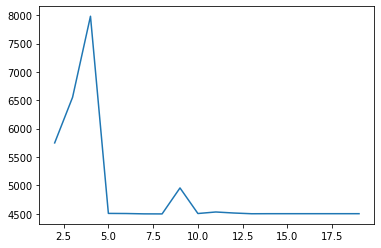

In [6]:
losses.plot.line()

It seems to be decreasing until size reaches 10 and then it levels off

## Q2: Epochs


Set the activation function to be ReLu, and set the number of nodes to be whatever
you chose from Q1.

Fit your model with 1, 10, 100, and 1000 epochs.



Again, instead of looking at just the one best choice, look at how your accuracy and/or
ROC-AUC scores change as you increase the number of epochs  What pattern do you
see?  How many epochs do you think are necessary for "convergence" to a good model?


In [7]:
losses = np.array([0]*4)
n_epoch = [1, 10, 100, 1000]
for i, n in enumerate(n_epoch):
  nn = NeuralNet([
                  Linear(22, 10),
                  ReLu(),
                  Linear(10, 7),
                  ReLu(),
                ])

  losses[i] = train(net = nn,
                    inputs = xtr,
                    targets = ytr,
                    num_epochs = n,
                    iterator = BatchIterator(),
                    loss = TSE(),
                    optimizer = SGD(lr = .01))
print(losses)
losses = pd.Series(losses, index=n_epoch)

[12379  4545  4469  4500]


10 is alot better than 1 epoch, but then there isnt much change. I also reduced the learning rate from .001 to .0001

<AxesSubplot:>

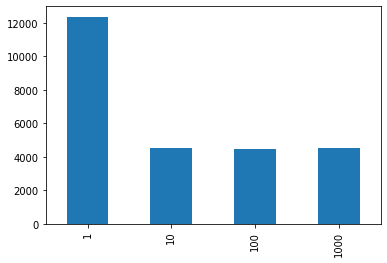

In [8]:
losses.plot.bar()

## Q3: Activation function


Set the number of nodes to be whatever you chose from Q1, and choose an epoch
number that seems reasonable based on Q2.

Try your model with all possible values of the activation function.



Comment on the results - was there much difference in your model success between
different choices?  Which one do you think is best?


In [9]:
activations = [ReLu(), Tanh(), Sigmoid()]

I only implememented 3 activations. Ideally in a clasification problem Softmax or something similar would be used on the output layer but I havent been able to figure out the derivative of it yet so instead I will have to make due with what I have so far

In [10]:
losses = np.array([0]*3)
for i, act in enumerate(activations):
  nn = NeuralNet([
                  Linear(22, 7),
                  act,
                  Linear(7, 7),
                  act
                ])
  losses[i] = train(net = nn,
                    inputs = xtr,
                    targets = ytr,
                    num_epochs = 100,
                    iterator = BatchIterator(),
                    loss = TSE(),
                    optimizer = SGD(lr = .01))
print(losses)
losses = pd.Series(losses, index=["Relu", "Tanh", "Sigmoid"])

[4499 1750 1733]


<AxesSubplot:>

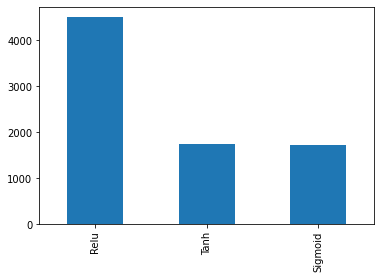

In [11]:
losses.plot.bar()

# Part Two: Prediction



Use your final model to predict on the validation set.

Report a confusion matrix of the predictions, and comment on it.

In [12]:
i = 2
nn = NeuralNet([Linear(22, 7),
                Sigmoid(),
                Linear(7, 7),
                Sigmoid()])
train(net = nn,
      inputs = xtr,
      targets = ytr,  
      num_epochs = 1000,
      iterator = BatchIterator(),
      loss = TSE(),
      optimizer = SGD(lr = .01),
      print_loss=10)

(nn.forward(ct.transform(cc_validate)).argmax(1)==cc_validate.STATUS_WORST).mean()

0.768

In [13]:
nn.forward(ct.transform(cc_validate)).argmax(1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
confusion_matrix(nn.forward(ct.transform(cc_validate)).argmax(1), cc_validate.STATUS_WORST)

array([[  0,   0,   0,   0,   0,   0,   0],
       [ 58, 384,  50,   4,   1,   1,   2],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0]])


# Part Three: Interpretation



Although we generally find Neural Networks to be very uninterpretable, there
are a few tricks we can use.

One is to make "fake" input, and see how changes to a single variable impact
the results.

Let's create a fake "average" person by assigning them the approximate average values from the full dataset:

In [15]:
fake_person = pd.DataFrame({
  "CODE_GENDER" : "F",
  "AGE" : 44,
  "EDUCATION_LEVEL" : "High School Degree",
  "FAMILY_STATUS" : "Married",
  "AMT_INCOME_TOTAL" : 18600,
  "HOUSING_TYPE" : "House / apartment",
  "IS_EMPLOYED" : "Y",
  "CNT_CHILDREN" : 0,
  "CNT_FAM_MEMBERS" : 2},
  index=[0])

This isnt the perfect way of doing this but should get the gist of what we are trying to do

In [16]:
def predProba(preds):
  return pd.Series(np.maximum((preds/preds.sum())[0], 0))

## Q1: Predicted Probabilities


Use your model to predict this person's STATUS_WORST value.  Instead of looking at the single predicted class, look at the estimated probabilities of each class.


array([[3.30380748e-02, 9.36226916e-01, 2.74902805e-02, 8.45206822e-03,
        1.34545522e-03, 5.69812625e-04, 1.38270620e-03]])

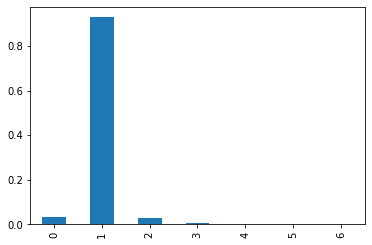

In [22]:
preds = nn.forward(ct.transform(fake_person))
predProba(preds).plot.bar()
preds

## Q2: Quantitative variable


Choose one of the quantitative variables.  Try changing it to a different value, and re-compute the predicted probabilities.  How did they change?  Do this a few times for a few different values.

What does this tell you in real world terms about how the model makes decisions?

(For example, you might say "Older people are more likely to pay on time, i.e. STATUS 1")


<AxesSubplot:>

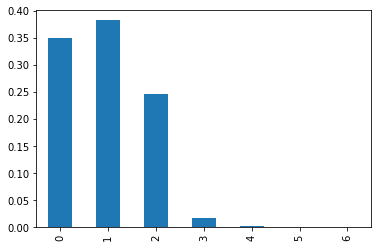

In [18]:
fake_person = pd.DataFrame({
  "CODE_GENDER" : "F",
  "AGE" : 44,
  "EDUCATION_LEVEL" : "High School Degree",
  "FAMILY_STATUS" : "Married",
  "AMT_INCOME_TOTAL" : 18600,
  "HOUSING_TYPE" : "House / apartment",
  "IS_EMPLOYED" : "Y",
  "CNT_CHILDREN" : 0,
  "CNT_FAM_MEMBERS" : 4},
  index=[0])
preds = nn.forward(ct.transform(fake_person))
predProba(preds).plot.bar()

<AxesSubplot:>

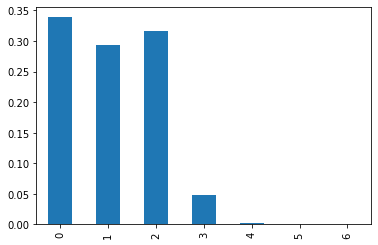

In [19]:
fake_person = pd.DataFrame({
  "CODE_GENDER" : "F",
  "AGE" : 44,
  "EDUCATION_LEVEL" : "High School Degree",
  "FAMILY_STATUS" : "Married",
  "AMT_INCOME_TOTAL" : 18600,
  "HOUSING_TYPE" : "House / apartment",
  "IS_EMPLOYED" : "Y",
  "CNT_CHILDREN" : 0,
  "CNT_FAM_MEMBERS" : 6},
  index=[0])
preds = nn.forward(ct.transform(fake_person))
predProba(preds).plot.bar()

<AxesSubplot:>

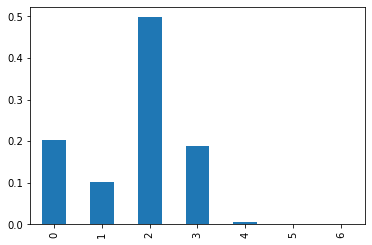

In [20]:
fake_person = pd.DataFrame({
  "CODE_GENDER" : "F",
  "AGE" : 44,
  "EDUCATION_LEVEL" : "High School Degree",
  "FAMILY_STATUS" : "Married",
  "AMT_INCOME_TOTAL" : 18600,
  "HOUSING_TYPE" : "House / apartment",
  "IS_EMPLOYED" : "Y",
  "CNT_CHILDREN" : 0,
  "CNT_FAM_MEMBERS" : 8},
  index=[0])
preds = nn.forward(ct.transform(fake_person))
predProba(preds).plot.bar()

## Q3: Categorical Variable


Now choose one of the categorical variables.  Change its value to different categories, and see how the predicted probabilities change.

What does this tell you in real world terms about how the model makes decisions?

<AxesSubplot:>

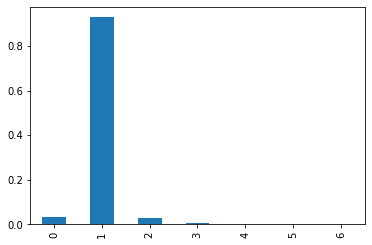

In [21]:
fake_person = pd.DataFrame({
  "CODE_GENDER" : "M",
  "AGE" : 44,
  "EDUCATION_LEVEL" : "High School Degree",
  "FAMILY_STATUS" : "Married",
  "AMT_INCOME_TOTAL" : 18600,
  "HOUSING_TYPE" : "With parents",
  "IS_EMPLOYED" : "N",
  "CNT_CHILDREN" : 0,
  "CNT_FAM_MEMBERS" : 2},
  index=[0])
preds = nn.forward(ct.transform(fake_person))
predProba(preds).plot.bar()